<a href="https://colab.research.google.com/github/AnantJainn/QuantumML/blob/main/QuantumML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 25.6 MB/s eta 0:00:00


Epoch 0 | Loss: 0.999999
Epoch 10 | Loss: 0.193933
Epoch 20 | Loss: 0.041361
Epoch 30 | Loss: 0.023035
Epoch 40 | Loss: 0.006784
Epoch 50 | Loss: 0.001766
Epoch 60 | Loss: 0.001141
Epoch 70 | Loss: 0.000414
Epoch 80 | Loss: 0.000240
Epoch 90 | Loss: 0.000156


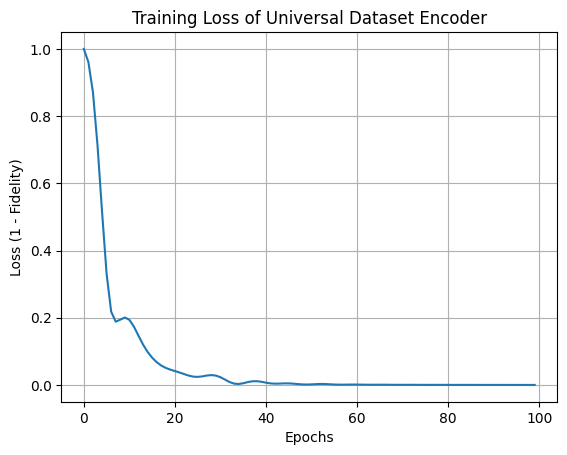

Final Fidelity: 0.999903


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt

# 1. Load & Normalize Sine Wave Dataset
x = np.linspace(0, 2 * np.pi, 16)
data = np.sin(x)
data = data / np.linalg.norm(data)  # normalize for amplitude encoding
target_state = torch.tensor(data, dtype=torch.float32)

# 2. Define Number of Qubits
n_qubits = int(np.log2(len(data)))
dev = qml.device("default.qubit", wires=n_qubits)

# 3. Hardware-Efficient Ansatz
def layer(weights):
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

# 4. UDE Quantum Circuit
@qml.qnode(dev, interface="torch")
def quantum_circuit(params):
    for l in range(params.shape[0]):
        layer(params[l])
    return qml.state()

# 5. Cost Function (Fidelity Loss)
def cost(params):
    pred_state = quantum_circuit(params)
    # Cast target_state to the same complex dtype as pred_state
    target_state_complex = target_state.to(pred_state.dtype)
    fidelity = torch.abs(torch.dot(pred_state, target_state_complex)) ** 2
    return 1 - fidelity  # 1 - fidelity = loss

# 6. Initialize Parameters
depth = 4
params = torch.nn.Parameter(0.01 * torch.randn((depth, n_qubits), requires_grad=True))
optimizer = Adam([params], lr=0.1)

# 7. Train the Circuit
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    loss = cost(params)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# 8. Plot Loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss (1 - Fidelity)")
plt.title("Training Loss of Universal Dataset Encoder")
plt.grid()
plt.show()

# 9. Final Fidelity
final_state = quantum_circuit(params)
# Cast target_state to the same complex dtype as final_state for final fidelity calculation
target_state_complex_final = target_state.to(final_state.dtype)
fidelity = torch.abs(torch.dot(final_state, target_state_complex_final)) ** 2
print(f"Final Fidelity: {fidelity.item():.6f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 134MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 19.3MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 46.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.26MB/s]


Epoch 0 | Loss: 0.999999
Epoch 10 | Loss: 0.244771
Epoch 20 | Loss: 0.081714
Epoch 30 | Loss: 0.040664
Epoch 40 | Loss: 0.021133
Epoch 50 | Loss: 0.012377
Epoch 60 | Loss: 0.009236
Epoch 70 | Loss: 0.007775
Epoch 80 | Loss: 0.006999
Epoch 90 | Loss: 0.006746


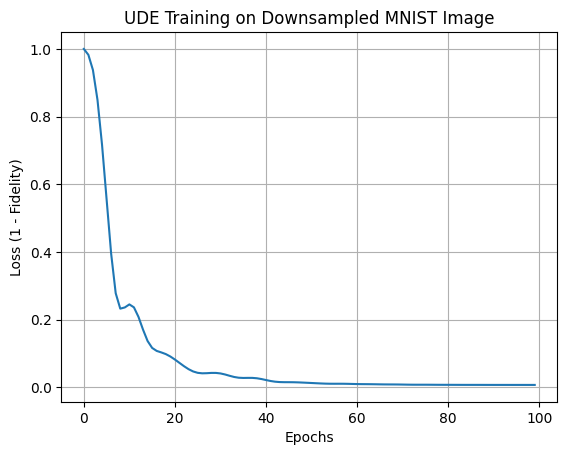

Final Fidelity: 0.993295


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

# ------------------------------
# 1. Load and Downsample MNIST
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((4, 4)),        # Downsample to 4x4
    transforms.ToTensor()
])

mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=1, shuffle=True)

# Get one sample image
img, label = next(iter(loader))
img = img.squeeze().flatten()  # shape: [16]
img_np = img.numpy()
img_np = img_np / np.linalg.norm(img_np)  # Normalize for amplitude encoding

# Convert to torch tensor
target_state = torch.tensor(img_np, dtype=torch.float32)

# ------------------------------
# 2. Setup Quantum Device
# ------------------------------
n_qubits = int(np.log2(len(target_state)))  # should be 4 for 16 values
dev = qml.device("default.qubit", wires=n_qubits)

# ------------------------------
# 3. Define Circuit
# ------------------------------
def layer(weights):
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev, interface="torch")
def quantum_circuit(params):
    for l in range(params.shape[0]):
        layer(params[l])
    return qml.state()

def cost(params):
    pred_state = quantum_circuit(params)
    target_complex = target_state.to(pred_state.dtype)
    fidelity = torch.abs(torch.dot(pred_state, target_complex)) ** 2
    return 1 - fidelity

# ------------------------------
# 4. Train UDE
# ------------------------------
depth = 4
params = torch.nn.Parameter(0.01 * torch.randn((depth, n_qubits), requires_grad=True))
optimizer = Adam([params], lr=0.1)

losses = []
for epoch in range(100):
    optimizer.zero_grad()
    loss = cost(params)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# ------------------------------
# 5. Visualize Loss
# ------------------------------
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss (1 - Fidelity)")
plt.title("UDE Training on Downsampled MNIST Image")
plt.grid()
plt.show()

# ------------------------------
# 6. Final Fidelity
# ------------------------------
final_state = quantum_circuit(params)
target_state_complex = target_state.to(final_state.dtype)
fidelity = torch.abs(torch.dot(final_state, target_state_complex)) ** 2
print(f"Final Fidelity: {fidelity.item():.6f}")


Epoch 0 | Loss Img1: 0.9998, Img2: 1.0000, Total: 1.9998
Epoch 10 | Loss Img1: 0.5290, Img2: 1.0000, Total: 1.5290
Epoch 20 | Loss Img1: 0.0667, Img2: 1.0000, Total: 1.0667
Epoch 30 | Loss Img1: 0.0546, Img2: 1.0000, Total: 1.0546
Epoch 40 | Loss Img1: 0.0519, Img2: 1.0000, Total: 1.0519
Epoch 50 | Loss Img1: 0.0513, Img2: 1.0000, Total: 1.0513
Epoch 60 | Loss Img1: 0.0511, Img2: 1.0000, Total: 1.0511
Epoch 70 | Loss Img1: 0.0511, Img2: 1.0000, Total: 1.0511
Epoch 80 | Loss Img1: 0.0511, Img2: 1.0000, Total: 1.0511
Epoch 90 | Loss Img1: 0.0511, Img2: 1.0000, Total: 1.0511


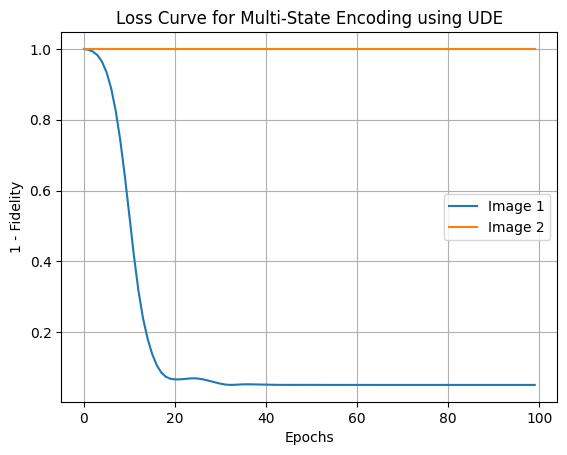

Fidelity of Image 1: 0.948870
Fidelity of Image 2: 0.000000


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load Two MNIST Samples
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((4, 4)),
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
img1, _ = mnist[0]
img2, _ = mnist[1]

# Preprocess
img1 = img1.squeeze().flatten().numpy()
img2 = img2.squeeze().flatten().numpy()
img1 = img1 / np.linalg.norm(img1)
img2 = img2 / np.linalg.norm(img2)

target_states = [torch.tensor(img1, dtype=torch.float32), torch.tensor(img2, dtype=torch.float32)]

# ------------------------------
# 2. Define Device (Ancilla + Data Qubits)
# ------------------------------
n_data_qubits = int(np.log2(len(img1)))  # 4 for 16 values
total_qubits = 1 + n_data_qubits         # 1 ancilla + 4 data
dev = qml.device("default.qubit", wires=total_qubits)

# ------------------------------
# 3. Define Multi-State VQC Controlled by Ancilla
# ------------------------------
def conditional_layer(weights, ancilla, data_wires):
    # Apply RY gates on data wires conditioned on the ancilla state
    qml.ctrl(qml.RY, control=ancilla)(weights[0], wires=data_wires[0])
    qml.ctrl(qml.RY, control=ancilla)(weights[1], wires=data_wires[1])
    qml.ctrl(qml.RY, control=ancilla)(weights[2], wires=data_wires[2])
    qml.ctrl(qml.RY, control=ancilla)(weights[3], wires=data_wires[3])
    # Add entanglement conditioned on the ancilla state
    qml.ctrl(qml.CNOT, control=ancilla)(wires=[data_wires[0], data_wires[1]])
    qml.ctrl(qml.CNOT, control=ancilla)(wires=[data_wires[1], data_wires[2]])
    qml.ctrl(qml.CNOT, control=ancilla)(wires=[data_wires[2], data_wires[3]])


@qml.qnode(dev, interface="torch")
def multi_state_encoder(params, index):  # index: 0 or 1 to select img1 or img2
    ancilla = 0
    data_wires = list(range(1, total_qubits))

    # Prepare ancilla based on the index
    if index == 0:
        qml.PauliX(wires=ancilla)  # flip to |1⟩ for img1 (index 0)
    # else it stays at |0⟩ for img2 (index 1)

    # Apply the conditional layers
    conditional_layer(params[index], ancilla, data_wires)


    return qml.state()

# ------------------------------
# 4. Cost Function
# ------------------------------
def cost(params, index):
    pred_state = multi_state_encoder(params, index)
    # Correct slicing based on ancilla state (controlled by index)
    if index == 0: # Ancilla was flipped to |1>, take the second half
        sliced = pred_state[2**n_data_qubits :]
    else: # Ancilla is |0>, take the first half
        sliced = pred_state[: 2**n_data_qubits]

    target = target_states[index].to(sliced.dtype)
    fidelity = torch.abs(torch.dot(sliced, target)) ** 2
    return 1 - fidelity

# ------------------------------
# 5. Training
# ------------------------------
params = torch.nn.Parameter(0.01 * torch.randn((2, 4), requires_grad=True))  # 2 images, 4 qubits each
optimizer = Adam([params], lr=0.1)
epochs = 100
losses = [[], []]

for epoch in range(epochs):
    total_loss = 0
    for i in range(2):  # train both states
        optimizer.zero_grad()
        loss = cost(params, i)
        loss.backward()
        optimizer.step()
        losses[i].append(loss.item())
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss Img1: {losses[0][-1]:.4f}, Img2: {losses[1][-1]:.4f}, Total: {total_loss:.4f}")

# ------------------------------
# 6. Plot Loss Curves
# ------------------------------
plt.plot(losses[0], label="Image 1")
plt.plot(losses[1], label="Image 2")
plt.title("Loss Curve for Multi-State Encoding using UDE")
plt.xlabel("Epochs")
plt.ylabel("1 - Fidelity")
plt.grid()
plt.legend()
plt.show()

# ------------------------------
# 7. Final Fidelity
# ------------------------------
for i in range(2):
    pred = multi_state_encoder(params, i)
    # Correct slicing for final fidelity calculation
    if i == 0:
        sliced = pred[2**n_data_qubits :]
    else:
        sliced = pred[: 2**n_data_qubits]

    fid = torch.abs(torch.dot(sliced, target_states[i].to(sliced.dtype))) ** 2
    print(f"Fidelity of Image {i+1}: {fid.item():.6f}")

Epoch 0 | Img1 Loss: 1.0000, Img2 Loss: 0.9775, Total: 1.9775
Epoch 10 | Img1 Loss: 0.1217, Img2 Loss: 0.0793, Total: 0.2010
Epoch 20 | Img1 Loss: 0.0573, Img2 Loss: 0.0352, Total: 0.0924
Epoch 30 | Img1 Loss: 0.0426, Img2 Loss: 0.0494, Total: 0.0920
Epoch 40 | Img1 Loss: 0.0408, Img2 Loss: 0.0512, Total: 0.0921
Epoch 50 | Img1 Loss: 0.0435, Img2 Loss: 0.0485, Total: 0.0920
Epoch 60 | Img1 Loss: 0.0440, Img2 Loss: 0.0479, Total: 0.0919
Epoch 70 | Img1 Loss: 0.0438, Img2 Loss: 0.0480, Total: 0.0919
Epoch 80 | Img1 Loss: 0.0437, Img2 Loss: 0.0481, Total: 0.0919
Epoch 90 | Img1 Loss: 0.0438, Img2 Loss: 0.0481, Total: 0.0919


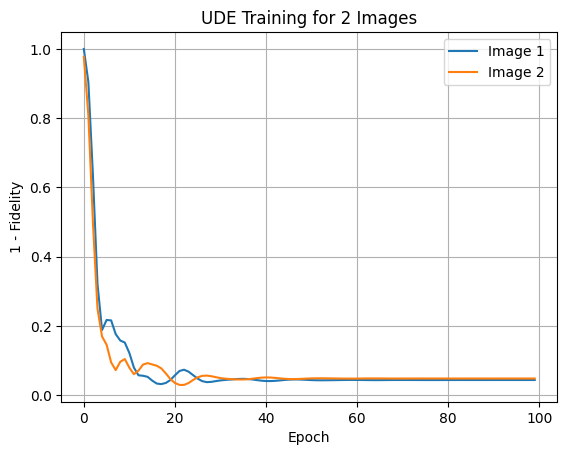

Final Fidelity for Image 1: 0.956180
Final Fidelity for Image 2: 0.955778


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------------------------
# 1. Load Two MNIST Samples
# ---------------------------------
transform = transforms.Compose([
    transforms.Resize((4, 4)),
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
img1, _ = mnist[0]
img2, _ = mnist[1]

# Flatten, normalize
img1 = img1.squeeze().flatten().numpy()
img2 = img2.squeeze().flatten().numpy()
img1 = img1 / np.linalg.norm(img1)
img2 = img2 / np.linalg.norm(img2)

target_states = [torch.tensor(img1, dtype=torch.float32), torch.tensor(img2, dtype=torch.float32)]

# ---------------------------------
# 2. Quantum Device (4 qubits)
# ---------------------------------
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# ---------------------------------
# 3. Shared Hardware-Efficient Ansatz
# ---------------------------------
def layer(weights):
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev, interface="torch")
def quantum_circuit(params):
    for l in range(params.shape[0]):
        layer(params[l])
    return qml.state()

def cost(params, index):
    pred = quantum_circuit(params)
    target = target_states[index].to(pred.dtype)
    fidelity = torch.abs(torch.dot(pred, target)) ** 2
    return 1 - fidelity

# ---------------------------------
# 4. Train on Two States Alternately
# ---------------------------------
depth = 4
params = torch.nn.Parameter(0.01 * torch.randn((depth, n_qubits), requires_grad=True))
optimizer = Adam([params], lr=0.1)
losses = [[], []]

for epoch in range(100):
    total_loss = 0
    for i in range(2):  # For both images
        optimizer.zero_grad()
        loss = cost(params, i)
        loss.backward()
        optimizer.step()
        losses[i].append(loss.item())
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Img1 Loss: {losses[0][-1]:.4f}, Img2 Loss: {losses[1][-1]:.4f}, Total: {total_loss:.4f}")

# ---------------------------------
# 5. Plot Loss
# ---------------------------------
plt.plot(losses[0], label="Image 1")
plt.plot(losses[1], label="Image 2")
plt.xlabel("Epoch")
plt.ylabel("1 - Fidelity")
plt.title("UDE Training for 2 Images")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------
# 6. Final Fidelity
# ---------------------------------
for i in range(2):
    pred = quantum_circuit(params)
    fidelity = torch.abs(torch.dot(pred, target_states[i].to(pred.dtype))) ** 2
    print(f"Final Fidelity for Image {i+1}: {fidelity.item():.6f}")


Epoch 0 | Img1 Loss: 1.0000, Img2 Loss: 0.9995, Total: 1.9995
Epoch 10 | Img1 Loss: 0.2998, Img2 Loss: 0.4994, Total: 0.7992
Epoch 20 | Img1 Loss: 0.2942, Img2 Loss: 0.3820, Total: 0.6762
Epoch 30 | Img1 Loss: 0.2669, Img2 Loss: 0.3862, Total: 0.6531
Epoch 40 | Img1 Loss: 0.2703, Img2 Loss: 0.3784, Total: 0.6487
Epoch 50 | Img1 Loss: 0.2692, Img2 Loss: 0.3785, Total: 0.6477
Epoch 60 | Img1 Loss: 0.2696, Img2 Loss: 0.3781, Total: 0.6477
Epoch 70 | Img1 Loss: 0.2695, Img2 Loss: 0.3780, Total: 0.6474
Epoch 80 | Img1 Loss: 0.2694, Img2 Loss: 0.3780, Total: 0.6474
Epoch 90 | Img1 Loss: 0.2693, Img2 Loss: 0.3779, Total: 0.6473


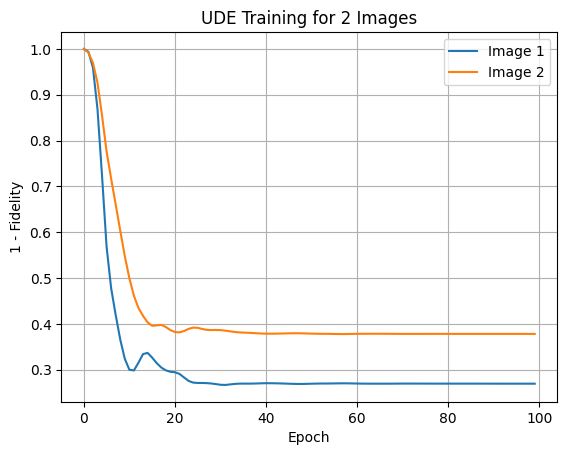

Final Fidelity for Image 1: 0.730740
Final Fidelity for Image 2: 0.626092


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------------------------
# 1. Load Two MNIST Samples
# ---------------------------------
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
img1, _ = mnist[0]
img2, _ = mnist[1]

# Flatten, normalize
img1 = img1.squeeze().flatten().numpy()
img2 = img2.squeeze().flatten().numpy()
img1 = img1 / np.linalg.norm(img1)
img2 = img2 / np.linalg.norm(img2)

target_states = [torch.tensor(img1, dtype=torch.float32), torch.tensor(img2, dtype=torch.float32)]

# ---------------------------------
# 2. Quantum Device (8 qubits for 16x16 images)
# ---------------------------------
n_qubits = int(np.log2(len(img1))) # Should be 8 for 256 elements (16x16)
dev = qml.device("default.qubit", wires=n_qubits)

# ---------------------------------
# 3. Shared Hardware-Efficient Ansatz
# ---------------------------------
def layer(weights):
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev, interface="torch")
def quantum_circuit(params):
    for l in range(params.shape[0]):
        layer(params[l])
    return qml.state()

def cost(params, index):
    pred = quantum_circuit(params)
    target = target_states[index].to(pred.dtype)
    fidelity = torch.abs(torch.dot(pred, target)) ** 2
    return 1 - fidelity

# ---------------------------------
# 4. Train on Two States Alternately
# ---------------------------------
depth = 4
params = torch.nn.Parameter(0.01 * torch.randn((depth, n_qubits), requires_grad=True))
optimizer = Adam([params], lr=0.1)
losses = [[], []]

for epoch in range(100):
    total_loss = 0
    for i in range(2):  # For both images
        optimizer.zero_grad()
        loss = cost(params, i)
        loss.backward()
        optimizer.step()
        losses[i].append(loss.item())
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Img1 Loss: {losses[0][-1]:.4f}, Img2 Loss: {losses[1][-1]:.4f}, Total: {total_loss:.4f}")

# ---------------------------------
# 5. Plot Loss
# ---------------------------------
plt.plot(losses[0], label="Image 1")
plt.plot(losses[1], label="Image 2")
plt.xlabel("Epoch")
plt.ylabel("1 - Fidelity")
plt.title("UDE Training for 2 Images")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------
# 6. Final Fidelity
# ---------------------------------
for i in range(2):
    pred = quantum_circuit(params)
    fidelity = torch.abs(torch.dot(pred, target_states[i].to(pred.dtype))) ** 2
    print(f"Final Fidelity for Image {i+1}: {fidelity.item():.6f}")

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(
100%|██████████| 9.91M/9.91M [00:00<00:00, 38.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 976kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.54MB/s]


Epoch 0 | Img1 Loss: 1.0000, Img2 Loss: 0.9995, Total: 1.9995
Epoch 10 | Img1 Loss: 0.3532, Img2 Loss: 0.5724, Total: 0.9256
Epoch 20 | Img1 Loss: 0.3036, Img2 Loss: 0.4354, Total: 0.7390
Epoch 30 | Img1 Loss: 0.2868, Img2 Loss: 0.4124, Total: 0.6991
Epoch 40 | Img1 Loss: 0.2568, Img2 Loss: 0.3924, Total: 0.6492
Epoch 50 | Img1 Loss: 0.2460, Img2 Loss: 0.3939, Total: 0.6399
Epoch 60 | Img1 Loss: 0.2482, Img2 Loss: 0.3882, Total: 0.6364
Epoch 70 | Img1 Loss: 0.2483, Img2 Loss: 0.3854, Total: 0.6337
Epoch 80 | Img1 Loss: 0.2484, Img2 Loss: 0.3826, Total: 0.6309
Epoch 90 | Img1 Loss: 0.2485, Img2 Loss: 0.3803, Total: 0.6288


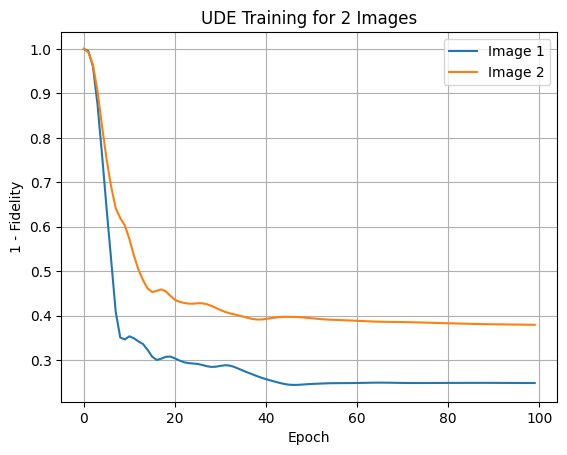

Final Fidelity for Image 1: 0.751867
Final Fidelity for Image 2: 0.625616


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------------------------
# 1. Load Two MNIST Samples
# ---------------------------------
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
img1, _ = mnist[0]
img2, _ = mnist[1]

# Flatten, normalize
img1 = img1.squeeze().flatten().numpy()
img2 = img2.squeeze().flatten().numpy()
img1 = img1 / np.linalg.norm(img1)
img2 = img2 / np.linalg.norm(img2)

target_states = [torch.tensor(img1, dtype=torch.float32), torch.tensor(img2, dtype=torch.float32)]

# ---------------------------------
# 2. Quantum Device (12 qubits for 64x64 images)
# ---------------------------------
n_qubits = int(np.log2(len(img1))) # Should be 12 for 4096 elements (64x64)
dev = qml.device("default.qubit", wires=n_qubits)

# ---------------------------------
# 3. Shared Hardware-Efficient Ansatz
# ---------------------------------
def layer(weights):
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev, interface="torch")
def quantum_circuit(params):
    for l in range(params.shape[0]):
        layer(params[l])
    return qml.state()

def cost(params, index):
    pred = quantum_circuit(params)
    target = target_states[index].to(pred.dtype)
    fidelity = torch.abs(torch.dot(pred, target)) ** 2
    return 1 - fidelity

# ---------------------------------
# 4. Train on Two States Alternately
# ---------------------------------
depth = 4
params = torch.nn.Parameter(0.01 * torch.randn((depth, n_qubits), requires_grad=True))
optimizer = Adam([params], lr=0.1)
losses = [[], []]

for epoch in range(100):
    total_loss = 0
    for i in range(2):  # For both images
        optimizer.zero_grad()
        loss = cost(params, i)
        loss.backward()
        optimizer.step()
        losses[i].append(loss.item())
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Img1 Loss: {losses[0][-1]:.4f}, Img2 Loss: {losses[1][-1]:.4f}, Total: {total_loss:.4f}")

# ---------------------------------
# 5. Plot Loss
# ---------------------------------
plt.plot(losses[0], label="Image 1")
plt.plot(losses[1], label="Image 2")
plt.xlabel("Epoch")
plt.ylabel("1 - Fidelity")
plt.title("UDE Training for 2 Images")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------
# 6. Final Fidelity
# ---------------------------------
for i in range(2):
    pred = quantum_circuit(params)
    fidelity = torch.abs(torch.dot(pred, target_states[i].to(pred.dtype))) ** 2
    print(f"Final Fidelity for Image {i+1}: {fidelity.item():.6f}")

Epoch 0 | Loss: 1.0000
Epoch 10 | Loss: 0.9941
Epoch 20 | Loss: 0.7423
Epoch 30 | Loss: 0.6482
Epoch 40 | Loss: 0.6473
Epoch 50 | Loss: 0.6462
Epoch 60 | Loss: 0.6314
Epoch 70 | Loss: 0.6131
Epoch 80 | Loss: 0.5123
Epoch 90 | Loss: 0.4213
Epoch 0 | Loss: 1.3544
Epoch 10 | Loss: 1.2744
Epoch 20 | Loss: 1.2551
Epoch 30 | Loss: 1.2426
Epoch 40 | Loss: 1.2395
Epoch 50 | Loss: 1.2336
Epoch 60 | Loss: 1.2272
Epoch 70 | Loss: 1.2233
Epoch 80 | Loss: 1.2178
Epoch 90 | Loss: 1.1950


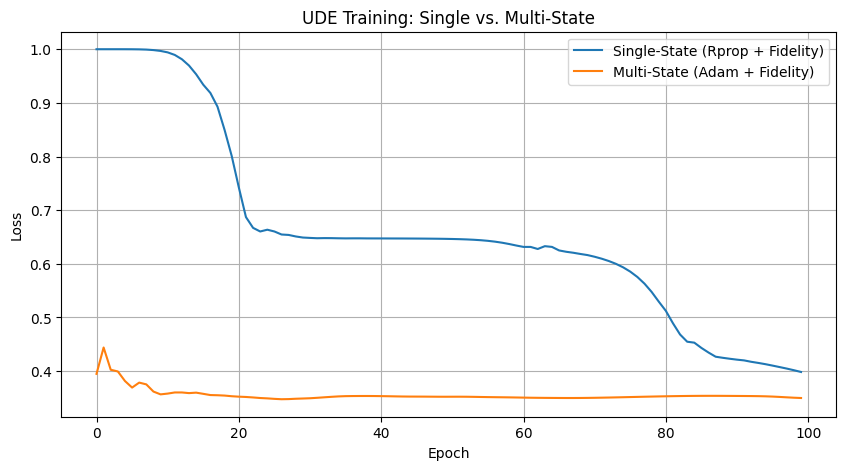

Fidelity for Image 1: 0.6506
Fidelity for Image 2: 0.1897


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, Rprop
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------------------------
# 1. Load and Preprocess Data (MNIST)
# ---------------------------------
transform = transforms.Compose([transforms.Resize((8, 8)), transforms.ToTensor()])  # 8x8 → 64D (6 qubits)
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
img1, _ = mnist[0]
img2, _ = mnist[1]

# Flatten and normalize
def preprocess(img):
    img = img.squeeze().flatten().numpy()
    return img / np.linalg.norm(img)

img1, img2 = preprocess(img1), preprocess(img2)
target_states = [torch.tensor(img1, dtype=torch.float32), torch.tensor(img2, dtype=torch.float32)]

# ---------------------------------
# 2. Quantum Device Setup (6 qubits + 1 ancilla)
# ---------------------------------
n_qubits = 6  # 2^6 = 64 (8x8 images)
n_ancilla = 1  # For multi-state encoding
dev = qml.device("default.qubit", wires=n_qubits + n_ancilla)

# ---------------------------------
# 3. UDE Circuit Architecture (Hardware-Efficient Ansatz)
# ---------------------------------
def layer(params, l):
    # Single-qubit rotations (RY gates)
    for i in range(n_qubits + n_ancilla):
        qml.RY(params[l, i], wires=i)

    # Circular entanglement (CRX gates)
    for i in range(n_qubits + n_ancilla):
        qml.CRX(params[l, n_qubits + n_ancilla], wires=[i, (i + 1) % (n_qubits + n_ancilla)]) # Corrected index for CRX parameter

@qml.qnode(dev, interface="torch")
def quantum_circuit(params, state_index=None):
    # Multi-state: Encode state_index into ancilla
    if state_index is not None:
        # Assuming state_index is 0 or 1
        if state_index == 1:
             qml.PauliX(wires=n_qubits) # Flip ancilla for state_index 1

    # Apply parameterized layers
    for l in range(params.shape[0]):
        layer(params, l)

    return qml.state()

# ---------------------------------
# 4. Cost Functions and Optimization
# ---------------------------------
def cost(params, state_index=None, cost_type="fidelity"):
    pred_state_vector = quantum_circuit(params, state_index)
    target = target_states[state_index] if state_index is not None else target_states[0] # Use target_states[0] for single state
    target = target.to(pred_state_vector.dtype)

    # Extract the relevant part of the predicted state vector
    if state_index is None or state_index == 0: # Ancilla is in |0> state
        pred = pred_state_vector[: 2**n_qubits]
    elif state_index == 1: # Ancilla is in |1> state
        pred = pred_state_vector[2**n_qubits :]
    else:
        raise ValueError("state_index must be 0 or 1 for multi-state encoding")


    if cost_type == "fidelity":
        fid = torch.abs(torch.dot(pred, target)) ** 2
        return 1 - fid
    elif cost_type == "mse":
        return torch.mean((torch.abs(pred) - torch.abs(target)) ** 2)
    elif cost_type == "l1":
        return torch.mean(torch.abs(torch.abs(pred) - torch.abs(target)))

# ---------------------------------
# 5. Training Loop (Single/Multi-State)
# ---------------------------------
depth = 4  # Initial depth (adjust dynamically)
params = torch.nn.Parameter(0.01 * torch.randn((depth, n_qubits + n_ancilla + 1), requires_grad=True))  # +1 for CRX params

def train(optimizer_type="adam", cost_type="fidelity", n_states=1):
    # Select optimizer
    if optimizer_type == "adam":
        optimizer = Adam([params], lr=0.1)
    elif optimizer_type == "rprop":
        optimizer = Rprop([params], lr=0.01)

    losses = [[] for _ in range(n_states)]

    for epoch in range(100):
        total_loss = 0
        for i in range(n_states):
            optimizer.zero_grad()
            loss = cost(params, i if n_states > 1 else None, cost_type)
            loss.backward()
            optimizer.step()
            losses[i].append(loss.item())
            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {total_loss:.4f}")

    return losses

# ---------------------------------
# 6. Evaluation and Visualization
# ---------------------------------
# Train single-state (Image 1)
losses_single = train(optimizer_type="rprop", cost_type="fidelity", n_states=1)

# Train multi-state (Images 1 & 2)
losses_multi = train(optimizer_type="adam", cost_type="fidelity", n_states=2)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_single[0], label="Single-State (Rprop + Fidelity)")
plt.plot(losses_multi[0], label="Multi-State (Adam + Fidelity)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("UDE Training: Single vs. Multi-State")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------
# 7. Final Fidelity Calculation
# ---------------------------------
for i in range(2):
    pred_state_vector = quantum_circuit(params, i)
    if i == 0:
        pred = pred_state_vector[: 2**n_qubits]
    elif i == 1:
        pred = pred_state_vector[2**n_qubits :]

    fidelity = torch.abs(torch.dot(pred, target_states[i].to(pred.dtype))) ** 2
    print(f"Fidelity for Image {i+1}: {fidelity.item():.4f}")

Epoch   0 | Total Loss: 1.0000
Epoch  10 | Total Loss: 0.9254
Epoch  20 | Total Loss: 0.6545
Epoch  30 | Total Loss: 0.4514
Epoch  40 | Total Loss: 0.2504
Epoch  50 | Total Loss: 0.2184
Epoch  60 | Total Loss: 0.1884
Epoch  70 | Total Loss: 0.1602
Epoch  80 | Total Loss: 0.1464
Epoch  90 | Total Loss: 0.1392
Epoch   0 | Total Loss: 2.0000
Epoch  10 | Total Loss: 0.8368
Epoch  20 | Total Loss: 0.5836
Epoch  30 | Total Loss: 0.4863
Epoch  40 | Total Loss: 0.4202
Epoch  50 | Total Loss: 0.3904
Epoch  60 | Total Loss: 0.3765
Epoch  70 | Total Loss: 0.3649
Epoch  80 | Total Loss: 0.3563
Epoch  90 | Total Loss: 0.3513


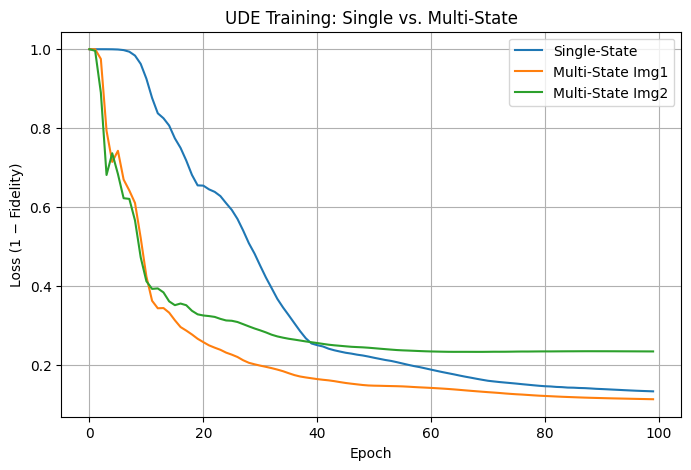


=== Single state fidelities ===
Image 1 Fidelity: 0.8671

=== Multi state fidelities ===
Image 1 Fidelity: 0.8869
Image 2 Fidelity: 0.7684


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, Rprop
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------------------------
# 1. Load and Preprocess Data (MNIST)
# ---------------------------------
# Downsample to 8×8 → 64 pixels → 6 qubits
transform = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
img1, _ = mnist[0]
img2, _ = mnist[1]

def preprocess(img):
    v = img.squeeze().flatten().numpy()
    return v / np.linalg.norm(v)

state1 = torch.tensor(preprocess(img1), dtype=torch.float32)
state2 = torch.tensor(preprocess(img2), dtype=torch.float32)
target_states = [state1, state2]

# ---------------------------------
# 2. Quantum Device Setup (Ancilla + Data Qubits)
# ---------------------------------
n_qubits = 6    # data qubits (8×8 → 64 dims)
n_ancilla = 1   # one ancilla
wires = ["a"] + [f"q{i}" for i in range(n_qubits)]
dev = qml.device("default.qubit", wires=wires)

# ---------------------------------
# 3. UDE Circuit Architecture
# ---------------------------------
def layer(params, layer_index):
    """One layer of RY rotations + circular CRX entanglement."""
    # RY on each wire (ancilla + data)
    for idx, w in enumerate(wires):
        qml.RY(params[layer_index, idx], wires=w)

    # Circular entanglement with CRX (unique param per link)
    num_wires = len(wires)
    for idx in range(num_wires):
        src = wires[idx]
        tgt = wires[(idx + 1) % num_wires]
        qml.CRX(params[layer_index, num_wires + idx], wires=[src, tgt])

@qml.qnode(dev, interface="torch")
def quantum_circuit(params, state_index=None):
    # Ancilla control: prepare |1> if encoding the second state
    if state_index == 1:
        qml.PauliX(wires="a")

    # Apply all layers
    for l in range(params.shape[0]):
        layer(params, l)

    return qml.state()

# ---------------------------------
# 4. Cost Function + Slicing Logic
# ---------------------------------
def cost(params, state_index, cost_type="fidelity"):
    vec = quantum_circuit(params, state_index)
    # post-select on ancilla:
    # indices 0..2^6-1 → ancilla=0, 2^6..2^7-1 → ancilla=1
    cut = 2 ** n_qubits
    if state_index == 0:
        pred = vec[:cut]
    else:
        pred = vec[cut:]
    target = target_states[state_index].to(pred.dtype)

    if cost_type == "fidelity":
        fid = torch.abs(torch.dot(pred, target)) ** 2
        return 1 - fid
    elif cost_type == "mse":
        return torch.mean((torch.abs(pred) - torch.abs(target)) ** 2)
    elif cost_type == "l1":
        return torch.mean(torch.abs(torch.abs(pred) - torch.abs(target)))
    else:
        raise ValueError(f"Unknown cost_type {cost_type}")

# ---------------------------------
# 5. Training Loop
# ---------------------------------
def train(n_states=1, optimizer_type="adam", cost_type="fidelity", epochs=100, lr=0.1):
    num_wires = n_qubits + n_ancilla
    # Initialize fresh params: depth × (data+ancilla + entanglers)
    depth = 4
    params = torch.nn.Parameter(
        0.01 * torch.randn((depth, num_wires + num_wires), requires_grad=True)
    )

    optimizer = Adam([params], lr=lr) if optimizer_type=="adam" else Rprop([params], lr=0.01)
    losses = [[] for _ in range(n_states)]

    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_states):
            optimizer.zero_grad()
            loss = cost(params, i, cost_type)
            loss.backward()
            optimizer.step()
            losses[i].append(loss.item())
            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Total Loss: {total_loss:.4f}")

    return params, losses

# ---------------------------------
# 6. Run Experiments
# ---------------------------------
# Single-state (only img1) with RProp + fidelity
params_single, losses_single = train(
    n_states=1, optimizer_type="rprop", cost_type="fidelity", epochs=100
)

# Multi-state (img1 & img2) with Adam + fidelity
params_multi, losses_multi = train(
    n_states=2, optimizer_type="adam", cost_type="fidelity", epochs=100
)

# ---------------------------------
# 7. Plotting
# ---------------------------------
plt.figure(figsize=(8,5))
plt.plot(losses_single[0], label="Single-State")
plt.plot(losses_multi[0], label="Multi-State Img1")
plt.plot(losses_multi[1], label="Multi-State Img2")
plt.xlabel("Epoch")
plt.ylabel("Loss (1 − Fidelity)")
plt.title("UDE Training: Single vs. Multi-State")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------
# 8. Final Fidelity
# ---------------------------------
for label, params_trained in [("Single", params_single), ("Multi", params_multi)]:
    print(f"\n=== {label} state fidelities ===")
    for i in range(1 if label=="Single" else 2):
        vec = quantum_circuit(params_trained, state_index=(i if label=="Multi" else None))
        cut = 2 ** n_qubits
        pred = vec[:cut] if i==0 else vec[cut:]
        fid = torch.abs(torch.dot(pred, target_states[i].to(pred.dtype)))**2
        print(f"Image {i+1} Fidelity: {fid.item():.4f}")


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, Rprop
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------------------------
# 1. Load and Preprocess Data (MNIST)
# ---------------------------------
# Downsample to 8×8 → 64 pixels → 6 qubits
transform = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
img1, _ = mnist[0]
img2, _ = mnist[1]

def preprocess(img):
    v = img.squeeze().flatten().numpy()
    return v / np.linalg.norm(v)

state1 = torch.tensor(preprocess(img1), dtype=torch.float32)
state2 = torch.tensor(preprocess(img2), dtype=torch.float32)
target_states = [state1, state2]

# ---------------------------------
# 2. Quantum Device Setup (Ancilla + Data Qubits)
# ---------------------------------
n_qubits = 6    # data qubits (8×8 → 64 dims)
n_ancilla = 1   # one ancilla
wires = ["a"] + [f"q{i}" for i in range(n_qubits)]
dev = qml.device("default.qubit", wires=wires)

# ---------------------------------
# 3. UDE Circuit Architecture
# ---------------------------------
def layer(params, layer_index):
    """One layer of RY rotations + circular CRX entanglement."""
    # RY on each wire (ancilla + data)
    for idx, w in enumerate(wires):
        qml.RY(params[layer_index, idx], wires=w)

    # Circular entanglement with CRX (unique param per link)
    num_wires = len(wires)
    for idx in range(num_wires):
        src = wires[idx]
        tgt = wires[(idx + 1) % num_wires]
        qml.CRX(params[layer_index, num_wires + idx], wires=[src, tgt])

@qml.qnode(dev, interface="torch")
def quantum_circuit(params, state_index=None):
    # Ancilla control: prepare |1> if encoding the second state
    if state_index == 1:
        qml.PauliX(wires="a")

    # Apply all layers
    for l in range(params.shape[0]):
        layer(params, l)

    return qml.state()

# ---------------------------------
# 4. Cost Function + Slicing Logic
# ---------------------------------
def cost(params, state_index, cost_type="fidelity"):
    vec = quantum_circuit(params, state_index)
    # post-select on ancilla:
    # indices 0..2^6-1 → ancilla=0, 2^6..2^7-1 → ancilla=1
    cut = 2 ** n_qubits
    if state_index == 0:
        pred = vec[:cut]
    else:
        pred = vec[cut:]
    target = target_states[state_index].to(pred.dtype)

    if cost_type == "fidelity":
        fid = torch.abs(torch.dot(pred, target)) ** 2
        return 1 - fid
    elif cost_type == "mse":
        return torch.mean((torch.abs(pred) - torch.abs(target)) ** 2)
    elif cost_type == "l1":
        return torch.mean(torch.abs(torch.abs(pred) - torch.abs(target)))
    else:
        raise ValueError(f"Unknown cost_type {cost_type}")

# ---------------------------------
# 5. Training Loop
# ---------------------------------
def train(n_states=1, optimizer_type="adam", cost_type="fidelity", epochs=100, lr=0.1):
    num_wires = n_qubits + n_ancilla
    # Initialize fresh params: depth × (data+ancilla + entanglers)
    depth = 8
    params = torch.nn.Parameter(
        0.01 * torch.randn((depth, num_wires + num_wires), requires_grad=True)
    )

    optimizer = Adam([params], lr=lr) if optimizer_type=="adam" else Rprop([params], lr=0.01)
    losses = [[] for _ in range(n_states)]

    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_states):
            optimizer.zero_grad()
            loss = cost(params, i, cost_type)
            loss.backward()
            optimizer.step()
            losses[i].append(loss.item())
            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Total Loss: {total_loss:.4f}")

    return params, losses

# ---------------------------------
# 6. Run Experiments
# ---------------------------------
# Single-state (only img1) with RProp + fidelity
params_single, losses_single = train(
    n_states=1, optimizer_type="rprop", cost_type="fidelity", epochs=100
)

# Multi-state (img1 & img2) with Adam + fidelity
params_multi, losses_multi = train(
    n_states=2, optimizer_type="adam", cost_type="fidelity", epochs=100
)

# ---------------------------------
# 7. Plotting
# ---------------------------------
plt.figure(figsize=(8,5))
plt.plot(losses_single[0], label="Single-State")
plt.plot(losses_multi[0], label="Multi-State Img1")
plt.plot(losses_multi[1], label="Multi-State Img2")
plt.xlabel("Epoch")
plt.ylabel("Loss (1 − Fidelity)")
plt.title("UDE Training: Single vs. Multi-State")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------
# 8. Final Fidelity
# ---------------------------------
for label, params_trained in [("Single", params_single), ("Multi", params_multi)]:
    print(f"\n=== {label} state fidelities ===")
    for i in range(1 if label=="Single" else 2):
        vec = quantum_circuit(params_trained, state_index=(i if label=="Multi" else None))
        cut = 2 ** n_qubits
        pred = vec[:cut] if i==0 else vec[cut:]
        fid = torch.abs(torch.dot(pred, target_states[i].to(pred.dtype)))**2
        print(f"Image {i+1} Fidelity: {fid.item():.4f}")


AttributeError: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

Epoch   0 | Total Loss: 0.9971
Epoch  10 | Total Loss: 0.6966
Epoch  20 | Total Loss: 0.2502
Epoch  30 | Total Loss: 0.1776
Epoch  40 | Total Loss: 0.1389
Epoch  50 | Total Loss: 0.1136
Epoch  60 | Total Loss: 0.0969
Epoch  70 | Total Loss: 0.0867
Epoch  80 | Total Loss: 0.0769
Epoch  90 | Total Loss: 0.0691
Epoch 100 | Total Loss: 0.0646
Epoch 110 | Total Loss: 0.0617
Epoch 120 | Total Loss: 0.0594
Epoch 130 | Total Loss: 0.0575
Epoch 140 | Total Loss: 0.0559
Epoch 150 | Total Loss: 0.0542
Epoch 160 | Total Loss: 0.0526
Epoch 170 | Total Loss: 0.0509
Epoch 180 | Total Loss: 0.0496
Epoch 190 | Total Loss: 0.0484
Epoch 200 | Total Loss: 0.0471
Epoch 210 | Total Loss: 0.0461
Epoch 220 | Total Loss: 0.0453
Epoch 230 | Total Loss: 0.0446
Epoch 240 | Total Loss: 0.0440
Epoch 250 | Total Loss: 0.0434
Epoch 260 | Total Loss: 0.0429
Epoch 270 | Total Loss: 0.0424
Epoch 280 | Total Loss: 0.0420
Epoch 290 | Total Loss: 0.0417
Epoch 300 | Total Loss: 0.0413
Epoch 310 | Total Loss: 0.0410
Epoch 32

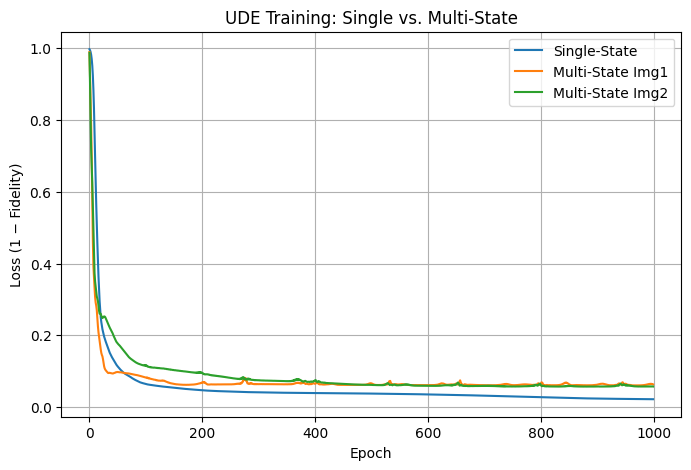


=== Single state fidelities ===
Image 1 Fidelity: 0.9778

=== Multi state fidelities ===
Image 1 Fidelity: 0.9364
Image 2 Fidelity: 0.9437

=== Predicted vs Target Amplitudes (Single-State) ===

Image 1 (first 10 amplitudes):
Predicted: [-0.0262, 0.0078, -0.0079, 0.0006, 0.0182, -0.0126, -0.0059, -0.018, -0.0028, 0.012, 0.0303, 0.0628, 0.0912, 0.0772, 0.0526, 0.0027, 0.0016, 0.0041, 0.1018, 0.2097, 0.1449, 0.0728, 0.0125, 0.001, 0.0012, -0.0027, 0.0178, 0.1029, 0.0603, 0.0202]
Target   : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.058, 0.1279, 0.1859, 0.1799, 0.1419, 0.006, 0.0, 0.008, 0.2079, 0.3937, 0.2858, 0.1319, 0.046, 0.002, 0.0, 0.0, 0.018, 0.2118, 0.1399, 0.018]

=== Predicted vs Target Amplitudes (Multi-State) ===

Image 1 (first 10 amplitudes):
Predicted: [0.0003, 0.0167, -0.0333, 0.0114, -0.0223, 0.027, 0.0061, 0.0128, 0.0124, -0.0002, 0.0662, 0.1368, 0.1917, 0.1405, 0.06, 0.0059, 0.0258, 0.0343, 0.2022, 0.3269, 0.2571, 0.1183, 0.0603, 0.027, 0.0098, 0.0262, 0.06

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, Rprop
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------------------------
# 1. Load and Preprocess Data (MNIST)
# ---------------------------------
# Downsample to 8×8 → 64 pixels → 6 qubits
transform = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
img1, _ = mnist[0]
img2, _ = mnist[1]

def preprocess(img):
    v = img.squeeze().flatten().numpy()
    return v / np.linalg.norm(v)

state1 = torch.tensor(preprocess(img1), dtype=torch.float32)
state2 = torch.tensor(preprocess(img2), dtype=torch.float32)
target_states = [state1, state2]

# ---------------------------------
# 2. Quantum Device Setup (Ancilla + Data Qubits)
# ---------------------------------
n_qubits = 6    # data qubits (8×8 → 64 dims)
n_ancilla = 1   # one ancilla
wires = ["a"] + [f"q{i}" for i in range(n_qubits)]
dev = qml.device("default.qubit", wires=wires)

# ---------------------------------
# 3. UDE Circuit Architecture
# ---------------------------------
def layer(params, layer_index):
    """One layer of RY rotations + circular CRX entanglement."""
    # RY on each wire (ancilla + data)
    for idx, w in enumerate(wires):
        qml.RY(params[layer_index, idx], wires=w)

    # Circular entanglement with CRX (unique param per link)
    num_wires = len(wires)
    for idx in range(num_wires):
        src = wires[idx]
        tgt = wires[(idx + 1) % num_wires]
        qml.CRX(params[layer_index, num_wires + idx], wires=[src, tgt])

@qml.qnode(dev, interface="torch")
def quantum_circuit(params, state_index=None):
    # Ancilla control: prepare |1> if encoding the second state
    if state_index == 1:
        qml.PauliX(wires="a")

    # Apply all layers
    for l in range(params.shape[0]):
        layer(params, l)

    return qml.state()

# ---------------------------------
# 4. Cost Function + Slicing Logic
# ---------------------------------
def cost(params, state_index, cost_type="fidelity"):
    vec = quantum_circuit(params, state_index)
    # post-select on ancilla:
    # indices 0..2^6-1 → ancilla=0, 2^6..2^7-1 → ancilla=1
    cut = 2 ** n_qubits
    if state_index == 0:
        pred = vec[:cut]
    else:
        pred = vec[cut:]
    target = target_states[state_index].to(pred.dtype)

    if cost_type == "fidelity":
        fid = torch.abs(torch.dot(pred, target)) ** 2
        return 1 - fid
    elif cost_type == "mse":
        return torch.mean((torch.abs(pred) - torch.abs(target)) ** 2)
    elif cost_type == "l1":
        return torch.mean(torch.abs(torch.abs(pred) - torch.abs(target)))
    else:
        raise ValueError(f"Unknown cost_type {cost_type}")

# ---------------------------------
# 5. Training Loop
# ---------------------------------
def train(n_states=1, optimizer_type="adam", cost_type="fidelity", epochs=100, lr=0.1):
    num_wires = n_qubits + n_ancilla
    # Initialize fresh params: depth × (data+ancilla + entanglers)
    depth = 8
    # params = torch.nn.Parameter(
    #     0.01 * torch.randn((depth, num_wires + num_wires), requires_grad=True)
    # )
    params = torch.nn.Parameter(
        torch.randn((depth, num_wires * 2), requires_grad=True) * np.pi
    )


    optimizer = Adam([params], lr=lr) if optimizer_type=="adam" else Rprop([params], lr=0.01)
    losses = [[] for _ in range(n_states)]

    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_states):
            optimizer.zero_grad()
            loss = cost(params, i, cost_type)
            loss.backward()
            optimizer.step()
            losses[i].append(loss.item())
            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Total Loss: {total_loss:.4f}")

    return params, losses

# ---------------------------------
# 6. Run Experiments
# ---------------------------------
# Single-state (only img1) with RProp + fidelity
params_single, losses_single = train(
    n_states=1, optimizer_type="rprop", cost_type="fidelity", epochs=1000
)

# Multi-state (img1 & img2) with Adam + fidelity
params_multi, losses_multi = train(
    n_states=2, optimizer_type="adam", cost_type="fidelity", epochs=1000
)

# ---------------------------------
# 7. Plotting
# ---------------------------------
plt.figure(figsize=(8,5))
plt.plot(losses_single[0], label="Single-State")
plt.plot(losses_multi[0], label="Multi-State Img1")
plt.plot(losses_multi[1], label="Multi-State Img2")
plt.xlabel("Epoch")
plt.ylabel("Loss (1 − Fidelity)")
plt.title("UDE Training: Single vs. Multi-State")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------
# 8. Final Fidelity
# ---------------------------------
for label, params_trained in [("Single", params_single), ("Multi", params_multi)]:
    print(f"\n=== {label} state fidelities ===")
    for i in range(1 if label=="Single" else 2):
        vec = quantum_circuit(params_trained, state_index=(i if label=="Multi" else None))
        cut = 2 ** n_qubits
        pred = vec[:cut] if i==0 else vec[cut:]
        fid = torch.abs(torch.dot(pred, target_states[i].to(pred.dtype)))**2
        print(f"Image {i+1} Fidelity: {fid.item():.4f}")



# ---------------------------------
# 9. Log predicted vs actual states
# ---------------------------------
def log_predictions(label, params_trained, n_states):
    print(f"\n=== Predicted vs Target Amplitudes ({label}) ===")
    for i in range(n_states):
        vec = quantum_circuit(params_trained, state_index=i if n_states > 1 else None)
        cut = 2 ** n_qubits
        pred = vec[:cut] if i == 0 else vec[cut:]
        target = target_states[i].to(pred.dtype)

        print(f"\nImage {i+1} (first 10 amplitudes):")
        print(f"Predicted: {[round(x.real.item(), 4) for x in pred[:30]]}")
        print(f"Target   : {[round(x.real.item(), 4) for x in target[:30]]}")

# Log for single-state
log_predictions("Single-State", params_single, n_states=1)

# Log for multi-state
log_predictions("Multi-State", params_multi, n_states=2)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Epoch   0 | Loss: 0.9547
Epoch  20 | Loss: 0.0321
Epoch  40 | Loss: 0.0048
Epoch  60 | Loss: 0.0015
Epoch  80 | Loss: 0.0007
Epoch 100 | Loss: 0.0005
Epoch 120 | Loss: 0.0003
Epoch 140 | Loss: 0.0002
Epoch 160 | Loss: 0.0001
Epoch 180 | Loss: 0.0001
Epoch 200 | Loss: 0.0000
Epoch 220 | Loss: 0.0000
Epoch 240 | Loss: 0.0000
Epoch 260 | Loss: 0.0000
Epoch 280 | Loss: 0.0000
Epoch   0 | Loss: 3.7865
Epoch  20 | Loss: 0.2684
Epoch  40 | Loss: 0.1298
Epoch  60 | Loss: 0.1011
Epoch  80 | Loss: 0.0883
Epoch 100 | Loss: 0.0628
Epoch 120 | Loss: 0.0249
Epoch 140 | Loss: 0.0084
Epoch 160 | Loss: 0.0042
Epoch 180 | Loss: 0.0029
Epoch 200 | Loss: 0.0022
Epoch 220 | Loss: 0.0018
Epoch 240 | Loss: 0.0015
Epoch 260 | Loss: 0.0012
Epoch 280 | Loss: 0.0011
Epoch 300 | Loss: 0.0009
Epoch 320 | Loss: 0.0008
Epoch 340 | Loss: 0.0008
Epoch 360 | Loss: 0.0007
Epoch 380 | Loss: 0.0006
Epoch 400 | Loss: 0.0102
Epoch 420 | Loss: 0.0050
Epoch 440 | Loss: 0.0014
Epoch 460 | Loss: 0.0006
Epoch 480 | Loss: 0.0020


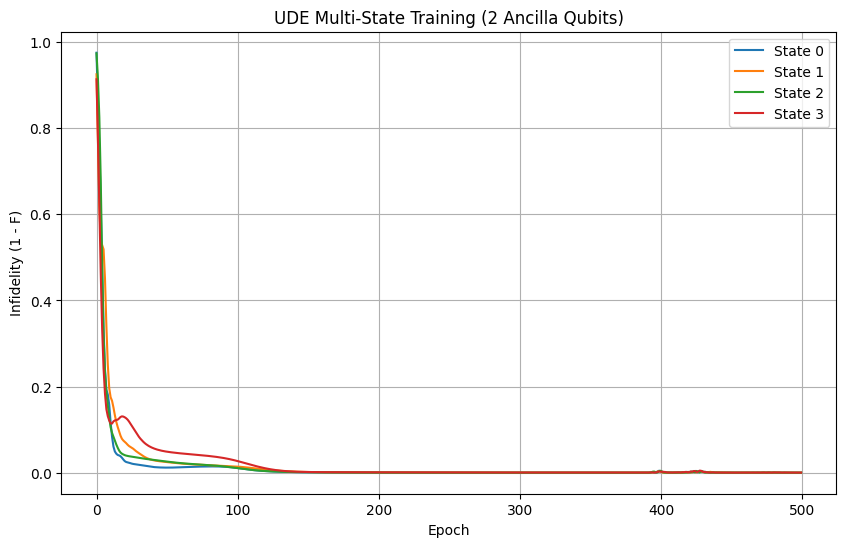

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam, Rprop
import matplotlib.pyplot as plt

# =============================================
# 1. Universal Data Preprocessing
# =============================================
def preprocess_data(data):
    """Normalize any input vector (image, time-series, or custom)."""
    if isinstance(data, torch.Tensor):
        data = data.numpy()
    data = np.array(data).flatten()
    return data / np.linalg.norm(data)

# Your thesis test cases (single and multi-state)
single_state_3q = [0.3, 0.2, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05]  # 3-qubit state
multi_states_2q = [
    [0.6, 0.5, 0.4, 0.4796],
    [0.5, 0.5, 0.5, 0.5],
    [0.8, 0.3, 0.4, 0.3317],
    [0.7071, 0, 0, 0.7071]
]  # 2-qubit states

# Preprocess all targets
target_states = [torch.tensor(preprocess_data(s), dtype=torch.float32) for s in multi_states_2q]

# =============================================
# 2. Quantum Device Setup (NISQ-Compatible)
# =============================================
n_qubits = 2  # For 2-qubit states (adjust for 3-qubit)
n_ancilla = 2  # Supports 4 states (2^2 ancilla combinations)
wires = [f"a{i}" for i in range(n_ancilla)] + [f"q{i}" for i in range(n_qubits)]
dev = qml.device("default.qubit", wires=wires)
# For noise simulation: dev = qml.device("default.mixed", wires=wires)

# =============================================
# 3. UDE Circuit Architecture (Adaptive Ansatz)
# =============================================
def adaptive_layer(params, layer_index, connectivity="circular"):
    """Hardware-efficient layer with configurable entanglement."""
    # Single-qubit rotations (RY on all qubits)
    for idx, w in enumerate(wires):
        qml.RY(params[layer_index, idx], wires=w)

    # Configurable entanglement
    num_wires = len(wires)
    if connectivity == "linear":
        for i in range(num_wires - 1):
            qml.CRX(params[layer_index, num_wires + i], wires=[wires[i], wires[i+1]])
    elif connectivity == "circular":
        for i in range(num_wires):
            src = wires[i]
            tgt = wires[(i + 1) % num_wires]
            qml.CRX(params[layer_index, num_wires + i], wires=[src, tgt])

@qml.qnode(dev, interface="torch")
def quantum_circuit(params, state_index=None):
    """UDE Circuit with ancilla-controlled state preparation."""
    # Ancilla-based state selection (e.g., state_index=2 → "10")
    if state_index is not None:
        binary = format(state_index, f"0{n_ancilla}b")
        for i, bit in enumerate(binary):
            if bit == "1":
                qml.PauliX(wires=f"a{i}")

    # Apply adaptive layers
    for l in range(params.shape[0]):
        adaptive_layer(params, l, connectivity="circular")

    return qml.state()

# =============================================
# 4. Cost Function (Fidelity + MSE/L1 Options)
# =============================================
def cost(params, state_index, cost_type="fidelity"):
    vec = quantum_circuit(params, state_index)
    # Post-select based on ancilla state
    cut = 2 ** n_qubits
    subspace = int(format(state_index, f"0{n_ancilla}b"), 2)
    pred = vec[subspace * cut : (subspace + 1) * cut]
    target = target_states[state_index].to(pred.dtype)

    if cost_type == "fidelity":
        fid = torch.abs(torch.dot(pred, target)) ** 2
        return 1 - fid
    elif cost_type == "mse":
        return torch.mean((torch.abs(pred) - torch.abs(target)) ** 2)
    elif cost_type == "l1":
        return torch.mean(torch.abs(torch.abs(pred) - torch.abs(target)))

# =============================================
# 5. Training Loop (Multi-State Optimization)
# =============================================
def train(n_states, optimizer_type="adam", cost_type="fidelity", epochs=200, lr=0.05):
    depth = 6  # Shallow depth for NISQ
    num_params_per_layer = len(wires) * 2  # RY + CRX params
    params = torch.nn.Parameter(
        torch.randn((depth, num_params_per_layer), requires_grad=True) * np.pi
    )

    optimizer = Adam([params], lr=lr) if optimizer_type == "adam" else Rprop([params], lr=0.01)
    losses = [[] for _ in range(n_states)]

    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_states):
            optimizer.zero_grad()
            loss = cost(params, i, cost_type)
            loss.backward()
            optimizer.step()
            losses[i].append(loss.item())
            total_loss += loss.item()

        if epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Loss: {total_loss:.4f}")

    return params, losses

# =============================================
# 6. Benchmarking
# =============================================
# Single-state training (state_index=0)
params_single, losses_single = train(
    n_states=1, optimizer_type="rprop", cost_type="fidelity", epochs=300
)

# Multi-state training (4 states)
params_multi, losses_multi = train(
    n_states=4, optimizer_type="adam", cost_type="fidelity", epochs=500
)

# =============================================
# 7. Results (Fidelity and State Comparison)
# =============================================
def evaluate_fidelity(params_trained, n_states):
    print("\n=== Fidelity Evaluation ===")
    for i in range(n_states):
        vec = quantum_circuit(params_trained, i)
        cut = 2 ** n_qubits
        subspace = int(format(i, f"0{n_ancilla}b"), 2)
        pred = vec[subspace * cut : (subspace + 1) * cut]
        target = target_states[i].to(pred.dtype)
        fid = torch.abs(torch.dot(pred, target)) ** 2
        print(f"State {i}: Fidelity = {fid.item():.4f}")

evaluate_fidelity(params_single, n_states=1)
evaluate_fidelity(params_multi, n_states=4)

# =============================================
# 8. Plotting
# =============================================
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(losses_multi[i], label=f"State {i}")
plt.xlabel("Epoch")
plt.ylabel("Infidelity (1 - F)")
plt.title("UDE Multi-State Training (2 Ancilla Qubits)")
plt.legend()
plt.grid()
plt.show()

--- Loading MNIST Dataset (Classes 0 and 1) ---


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.56MB/s]


Selected 50 images of class 0
Selected 50 images of class 1
Total selected images: 100
Class 0 features shape: (50, 784)
Class 1 features shape: (50, 784)
Combined features shape: (100, 784)
--- PCA for dimensionality reduction ---
After PCA: (100, 100)
--- Random projection to 256 ---

--- Target States from MNIST Classes 0 and 1 ---
Shape of target vectors: (2, 256)
Class 0 target vector norm: 1.000000
Class 1 target vector norm: 1.000000
-----------------------------------------
Using device: default.qubit with 9 wires.

--- Starting Training (MNIST Classes 0 and 1 targets) ---


/usr/local/lib/python3.12/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (100 < 256).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


Epoch    1 | Avg Loss 0.999210 | LR 0.005000
Epoch   20 | Avg Loss 0.785110 | LR 0.005000
Epoch   40 | Avg Loss 0.082933 | LR 0.005000
Epoch   60 | Avg Loss 0.048093 | LR 0.005000
Epoch   80 | Avg Loss 0.043363 | LR 0.005000
Epoch  100 | Avg Loss 0.042339 | LR 0.005000
Epoch  120 | Avg Loss 0.042177 | LR 0.005000
Epoch  140 | Avg Loss 0.042101 | LR 0.005000
Epoch  160 | Avg Loss 0.042042 | LR 0.005000
Epoch  180 | Avg Loss 0.041991 | LR 0.005000
Epoch  200 | Avg Loss 0.041947 | LR 0.005000
--- Training Complete ---

Training wall-time: 1362.0s

── Final Model Fidelities on MNIST Target States ──
Fidelity for MNIST class 0: 0.977340
Fidelity for MNIST class 1: 0.938769
─────────────────────────
Average fidelity: 0.958055
Minimum fidelity: 0.938769


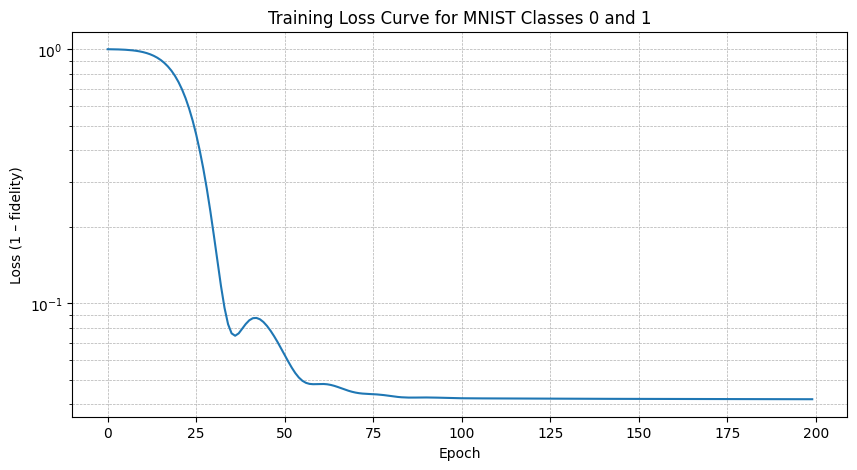

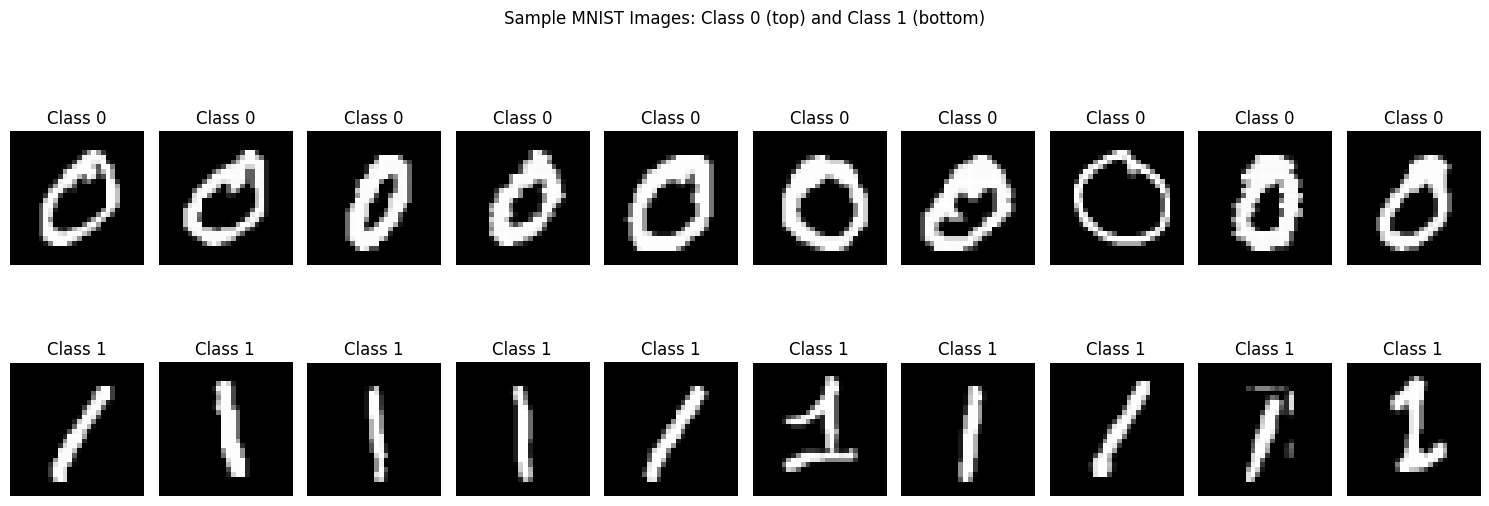


Target state overlap (class 0 vs class 1): 0.887577
Target state separation (1 - overlap): 0.112423
Predicted state overlap: 0.999917
Predicted state separation: 0.000083


In [ ]:
import math, random, time, os
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

# Extra sklearn utilities
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection

# ───────────────────────────────────────────────────────────
# 1. EXPERIMENT CONFIGURATION (MNIST, Classes 0 and 1)
# ───────────────────────────────────────────────────────────
SEED                = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

NUM_FEATURES        = 256                               # Target post-projection dimension (power of 2)
NUM_STATES          = 2                                 # Classes 0 and 1
WORK_QUBITS         = int(math.log2(NUM_FEATURES))      # 256 -> 8 data qubits
ANCILLA_QUBITS      = math.ceil(math.log2(NUM_STATES))  # 2 -> 1 ancilla qubit
TOTAL_QUBITS        = ANCILLA_QUBITS + WORK_QUBITS      # 9 total wires
WIRES               = list(range(TOTAL_QUBITS))
BATCH_SIZE          = 2                                 # Can handle both classes
DEPTH               = 10
LR                  = 5e-3
MAX_EPOCHS          = 200

# ───────────────────────────────────────────────────────────
# 2. DATASET (MNIST with 50 images each of classes 0 and 1)
# ───────────────────────────────────────────────────────────
print("--- Loading MNIST Dataset (Classes 0 and 1) ---")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter out 50 samples each of classes '0' and '1'
indices_class_0 = [i for i, (_, label) in enumerate(mnist_dataset) if label == 0][:50]
indices_class_1 = [i for i, (_, label) in enumerate(mnist_dataset) if label == 1][:50]

# Combine indices
selected_indices = indices_class_0 + indices_class_1
subset_selected = Subset(mnist_dataset, selected_indices)

print(f"Selected {len(indices_class_0)} images of class 0")
print(f"Selected {len(indices_class_1)} images of class 1")
print(f"Total selected images: {len(subset_selected)}")

# Convert images to feature vectors and separate by class
X_class_0 = []
X_class_1 = []

for i in range(len(subset_selected)):
    image, label = subset_selected[i]
    # Flatten 28x28 image to 784 features
    image_flat = image.view(-1).numpy()
    if label == 0:
        X_class_0.append(image_flat)
    elif label == 1:
        X_class_1.append(image_flat)

X_class_0 = np.array(X_class_0)  # Shape: (50, 784)
X_class_1 = np.array(X_class_1)  # Shape: (50, 784)
X_combined = np.vstack([X_class_0, X_class_1])  # Shape: (100, 784)

print(f"Class 0 features shape: {X_class_0.shape}")
print(f"Class 1 features shape: {X_class_1.shape}")
print(f"Combined features shape: {X_combined.shape}")

# Stage 1: PCA to reduce dimensionality while preserving information
print("--- PCA for dimensionality reduction ---")
# Use PCA to reduce from 784 to a reasonable intermediate dimension
pca_intermediate = PCA(n_components=min(100, X_combined.shape[1]), random_state=SEED)
X_pca = pca_intermediate.fit_transform(X_combined)
print(f"After PCA: {X_pca.shape}")

# Split back into classes after PCA
X_pca_class_0 = X_pca[:50]  # First 50 samples
X_pca_class_1 = X_pca[50:]  # Next 50 samples

# Stage 2: Random projection to 256 to match 2^8 amplitudes
print(f"--- Random projection to {NUM_FEATURES} ---")
rp = GaussianRandomProjection(n_components=NUM_FEATURES, random_state=SEED)
X_proj = rp.fit_transform(X_pca)  # shape: (100, 256)

# Split projected features by class
X_proj_class_0 = X_proj[:50]  # First 50 samples (class 0)
X_proj_class_1 = X_proj[50:]  # Next 50 samples (class 1)

# Scale features to non-negative range [0.1, 1.0]
scaler = MinMaxScaler(feature_range=(0.1, 1.0))
X_scaled = scaler.fit_transform(X_proj)

# Split scaled features by class
X_scaled_class_0 = X_scaled[:50]
X_scaled_class_1 = X_scaled[50:]

# Compute mean feature vectors for each class
mean_vector_0 = X_scaled_class_0.mean(axis=0)  # Shape: (256,)
mean_vector_1 = X_scaled_class_1.mean(axis=0)  # Shape: (256,)

# Combine mean vectors
mean_vectors = np.array([mean_vector_0, mean_vector_1])  # Shape: (2, 256)

# Normalize each mean vector to form valid target quantum states
norms = np.linalg.norm(mean_vectors, axis=1, keepdims=True)
Y_targets_np = mean_vectors / norms

print("\n--- Target States from MNIST Classes 0 and 1 ---")
print(f"Shape of target vectors: {Y_targets_np.shape}")
print(f"Class 0 target vector norm: {np.linalg.norm(Y_targets_np[0]):.6f}")
print(f"Class 1 target vector norm: {np.linalg.norm(Y_targets_np[1]):.6f}")
print("-----------------------------------------")

# Convert to PyTorch tensors for the model
Y_targets = torch.tensor(Y_targets_np, dtype=torch.complex128)
state_indices = torch.arange(NUM_STATES, dtype=torch.int64)  # [0, 1]

# Dataset of 2 class states
dataset = TensorDataset(Y_targets, state_indices)
loader  = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True,
    generator=torch.Generator().manual_seed(SEED)
)

# ───────────────────────────────────────────────────────────
# 3. QUANTUM DEVICE
# ───────────────────────────────────────────────────────────
dev = qml.device("default.qubit", wires=WIRES)
print(f"Using device: {dev.name} with {TOTAL_QUBITS} wires.")

# ───────────────────────────────────────────────────────────
# 4. PARAMETRIC CIRCUIT BUILDING BLOCKS
# ───────────────────────────────────────────────────────────
def entangle_block(phi, wires):
    num_wires = len(wires)
    for i in range(num_wires):
        qml.CRX(phi[i], wires=[wires[i], wires[(i + 1) % num_wires]])

class PQCLayer(nn.Module):
    def __init__(self, num_wires):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(num_wires) * 0.1)
        self.phi   = nn.Parameter(torch.randn(num_wires) * 0.1)
    def forward(self):
        return self.theta, self.phi

# ───────────────────────────────────────────────────────────
# 5. QNODE (state factory with ancilla selection)
# ───────────────────────────────────────────────────────────
@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(ry_thetas, crx_phis, state_idx):
    # Encode class index on ancilla qubits as basis state
    binary_state = [(state_idx >> i) & 1 for i in range(ANCILLA_QUBITS)]
    qml.BasisState(binary_state, wires=range(ANCILLA_QUBITS))

    # Create superposition on all wires
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Parameterized layers
    for i in range(DEPTH):
        for w in range(TOTAL_QUBITS):
            qml.RY(ry_thetas[i, w], wires=WIRES[w])
        entangle_block(crx_phis[i], wires=WIRES)

    # Interference via Hadamards
    for wire in WIRES:
        qml.Hadamard(wires=wire)

    # Return full statevector
    return qml.state()

# ───────────────────────────────────────────────────────────
# 6. HYBRID MODEL CONTAINER
# ───────────────────────────────────────────────────────────
class QuantumModel(nn.Module):
    def __init__(self, depth=DEPTH):
        super().__init__()
        self.layers = nn.ModuleList([PQCLayer(TOTAL_QUBITS) for _ in range(depth)])
    def get_params(self):
        thetas, phis = zip(*[layer() for layer in self.layers])
        return torch.stack(thetas), torch.stack(phis)
    def forward(self, indices):
        ry_thetas, crx_phis = self.get_params()
        states = [circuit(ry_thetas, crx_phis, idx.item()) for idx in indices]
        return torch.stack(states)

# ───────────────────────────────────────────────────────────
# 7. TRAINING UTILITIES
# ───────────────────────────────────────────────────────────
def fidelity(pred, target):
    inner = torch.sum(torch.conj(pred) * target, dim=1)
    return torch.abs(inner) ** 2

def cost(model, batch):
    y_b, idx_b = batch
    full_states = model(idx_b)  # shape: (B, 2**TOTAL_QUBITS) complex
    preds = []
    for i in range(len(idx_b)):
        state_idx = idx_b[i].item()
        full_state = full_states[i]
        # Slice out the WORK_QUBITS sector associated with this ancilla index
        offset = state_idx * (2 ** WORK_QUBITS)
        end    = offset + (2 ** WORK_QUBITS)
        pred = full_state[offset:end]
        preds.append(pred)
    preds = torch.stack(preds)
    preds = preds / torch.linalg.norm(preds, dim=1, keepdim=True)
    fids  = fidelity(preds, y_b)
    return (1. - fids).mean()

# ───────────────────────────────────────────────────────────
# 8. TRAINING LOOP
# ───────────────────────────────────────────────────────────
def train():
    model = QuantumModel()
    opt   = Adam(model.parameters(), lr=LR)
    sched = ReduceLROnPlateau(opt, factor=0.5, patience=20, min_lr=1e-6)
    losses = []
    print("\n--- Starting Training (MNIST Classes 0 and 1 targets) ---")
    for epoch in range(1, MAX_EPOCHS + 1):
        total_loss = 0.0
        for batch in loader:
            opt.zero_grad(set_to_none=True)
            loss = cost(model, batch)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        sched.step(avg_loss)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Avg Loss {avg_loss:.6f} | LR {opt.param_groups[0]['lr']:.6f}")
    print("--- Training Complete ---")
    return model, losses

# ───────────────────────────────────────────────────────────
# 9. MAIN EXECUTION
# ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    start = time.perf_counter()
    trained_model, history = train()
    print(f"\nTraining wall-time: {time.perf_counter() - start:.1f}s")

    print("\n── Final Model Fidelities on MNIST Target States ──")
    with torch.no_grad():
        ry_thetas, crx_phis = trained_model.get_params()
        fids = []
        for i in range(NUM_STATES):
            target_state = Y_targets[i]
            state_idx = i
            full_psi = circuit(ry_thetas, crx_phis, state_idx)
            offset = state_idx * (2 ** WORK_QUBITS)
            end    = offset + (2 ** WORK_QUBITS)
            pred = full_psi[offset:end]
            norm = torch.linalg.norm(pred)
            if norm > 1e-8:
                pred = pred / norm
            fid = torch.abs(torch.dot(torch.conj(pred), target_state)) ** 2
            fids.append(fid.item())
            print(f"Fidelity for MNIST class {i}: {fid.item():.6f}")

    print("─────────────────────────")
    print(f"Average fidelity: {np.mean(fids):.6f}")
    print(f"Minimum fidelity: {np.min(fids):.6f}")

    # Plotting training curve
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(history)
        plt.yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (1 – fidelity)")
        plt.title("Training Loss Curve for MNIST Classes 0 and 1")
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.show()
    except Exception:
        pass

    # Optional: Display sample images from both classes
    try:
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 10, figsize=(15, 6))

        # Display 10 samples from class 0
        for i in range(10):
            image, label = subset_selected[i]  # First 50 are class 0
            axes[0, i].imshow(image.squeeze(), cmap='gray')
            axes[0, i].set_title(f'Class {label}')
            axes[0, i].axis('off')

        # Display 10 samples from class 1
        for i in range(10):
            image, label = subset_selected[i + 50]  # Next 50 are class 1
            axes[1, i].imshow(image.squeeze(), cmap='gray')
            axes[1, i].set_title(f'Class {label}')
            axes[1, i].axis('off')

        plt.suptitle('Sample MNIST Images: Class 0 (top) and Class 1 (bottom)')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

    # Compute and display class separation metrics
    try:
        # Calculate similarity between the two target states
        state_0 = Y_targets[0].numpy()
        state_1 = Y_targets[1].numpy()

        # Inner product (overlap)
        overlap = np.abs(np.vdot(state_0, state_1))**2
        print(f"\nTarget state overlap (class 0 vs class 1): {overlap:.6f}")
        print(f"Target state separation (1 - overlap): {1 - overlap:.6f}")

        # Compute fidelity between predicted states
        with torch.no_grad():
            pred_0 = circuit(ry_thetas, crx_phis, 0)[0:256]
            pred_1 = circuit(ry_thetas, crx_phis, 1)[256:512]

            pred_0 = pred_0 / torch.linalg.norm(pred_0)
            pred_1 = pred_1 / torch.linalg.norm(pred_1)

            pred_overlap = torch.abs(torch.vdot(pred_0, pred_1))**2
            print(f"Predicted state overlap: {pred_overlap.item():.6f}")
            print(f"Predicted state separation: {1 - pred_overlap.item():.6f}")

    except Exception as e:
        print(f"Could not compute separation metrics: {e}")
